# Machine Learning Foundations


## Outline

1. Introduction
    - When to use ML
    - Types of ML
2. Features: selection and engineering
3. Scenario:  image processing and classification
    - Exploratory data analysis
    - Support Vector Machine classifier
4. Measures of a good model
    - Precision and recall
5. Featurization for more complex problems
    - Histogram of Oriented Gradients example
    - Scaling/normalizing example
3. Scenario:  predicting the stock market with regression
    - Decision trees
6. Classical ML vs. deep learning

## Datasets

- Climbing gear inventory image data
- [MSFT Stock market data](https://www.kaggle.com/darkknight91/microsoft-stock-price-daily-19982018)


In [1]:
# import sys
# ! {sys.executable} -m pip install -r requirements.txt

## Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import glob
import os
from PIL import Image, ImageOps

# Import util, classifiers and performance metrics
from sklearn.utils import shuffle
from sklearn import svm, metrics
from sklearn.model_selection import train_test_split

from skimage.feature import hog
from skimage import exposure

from utils import pad_image

# Plot inline in notebook
%matplotlib inline

# Make figures wider to see easier
plt.rcParams["figure.figsize"] = (16,3)
# Change axis area color to make it easier to see image area
plt.rcParams['figure.facecolor'] = 'grey'

## Scenario:  image processing and classification

### Image exploratory data analysis

Let's explore our image data with one test image.

In [3]:
def plot_rgb(img):
    """Plot the distribution of RGB intensities
    
    Arguments
    ---------
    img : 3D numpy array with values [0.0-1.0]
       input image
    """
    plt.hist(img[...,0].ravel(), color='red', bins=50, alpha=0.7)
    plt.hist(img[...,1].ravel(), color='green', bins=50, alpha=0.7)
    plt.hist(img[...,2].ravel(), color='blue', bins=50, alpha=0.7)

Read image with `matplotlib`

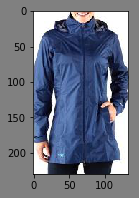

In [4]:
img = plt.imread('data/jacket.jpeg')
plt.imshow(img)

In [5]:
# Check the shape of the image (height, width, num channels)
img.shape

(230, 134, 3)

Use the utility function to square pad the image (ML algorithm will want square images all of the same size).

In [6]:
img_padded = pad_image(img)

In [7]:
# Check the shape again
img_padded.shape

(230, 230, 3)

Plot the padded image

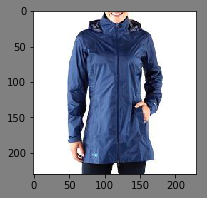

In [8]:
# Convert the 0-255 valued numpy array to unsigned int8 for plotting correctly
img_padded = img_padded.astype(np.uint8)
plt.imshow(img_padded)

Let's see what the distribution of RGB (separated) intensities is for the image using our `plot_rgb` function from above.

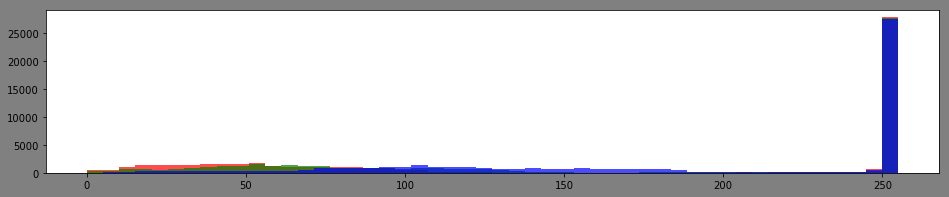

In [9]:
plot_rgb(img_padded)

What if we remove the most intense values (white) to reveal other RGB values?

In [10]:
# Copy image and normalize 0-1 rather than 1-255 so that we can use np.nan values
img2 = img_padded.copy()/255.
img2[img2 == 1.0] = np.nan

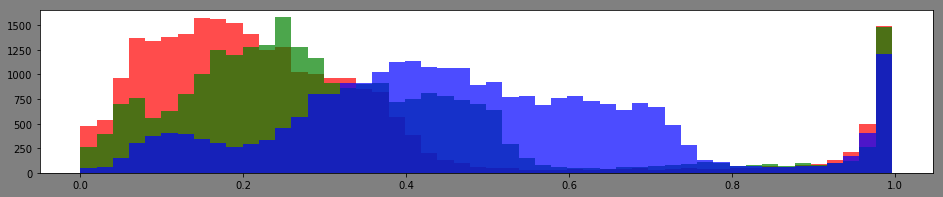

In [11]:
plot_rgb(img2)

### Image preprocessing

- Pad
- Resize

This has thankfully been taken care of for you - see `utils.py` on how it was done.

In [28]:
# Prepare images (pad and resize) - enter the directory of your original images
# A new directory with the same name appended with "64x64" will be made
# This has been done for you - see utils.py for how

In [15]:
! ls <your-path-to-folder>/gear_images_for_workshop_64x64/

boots             gloves            hardshell_jackets


### Create the dataset

In [16]:
def make_dataset(img_dir, labels_dict, randomize=True):
    """Create the image dataset.
    
    Arguments
    ---------
    img_dir : str
        The directory of square padded, same size images
        
    Returns
    -------
    images : list of numpy arrays
        The image data as an array of 3D numpy arrays
    targets : list of ints
        The labels as integers as an array of ints.
    """
    X = []
    y = []
    
    image_files = []
    for root, subdirs, files in os.walk(img_dir):
        image_files += [os.path.join(root, file) for file in files]
    
    # Read image into 3D numpy array and get class name
    for image_file in image_files:
        img = plt.imread(image_file)
        label = os.path.dirname(image_file).split(os.sep)[-1]        
        if label not in labels_dict:
            print("Error:  label not in dictionary.  Check image file paths.")
            break
        X.append(img)
        y.append(labels_dict[label])
        
        if randomize:
            X, y = shuffle(X, y, random_state=42)
    
    return np.array(X), y

In [17]:
# Make a dictionary of 0 indexed labels
labels_dict = {
    'boots': 0,
    'gloves': 1,
    'hardshell_jackets': 2
}

# To use later
labels_array = ['boots', 'gloves', 'hardshell_jackets']

In [18]:
X, y = make_dataset(img_dir='<your-path-to-folder>/gear_images_for_workshop_64x64',
                             labels_dict=labels_dict)

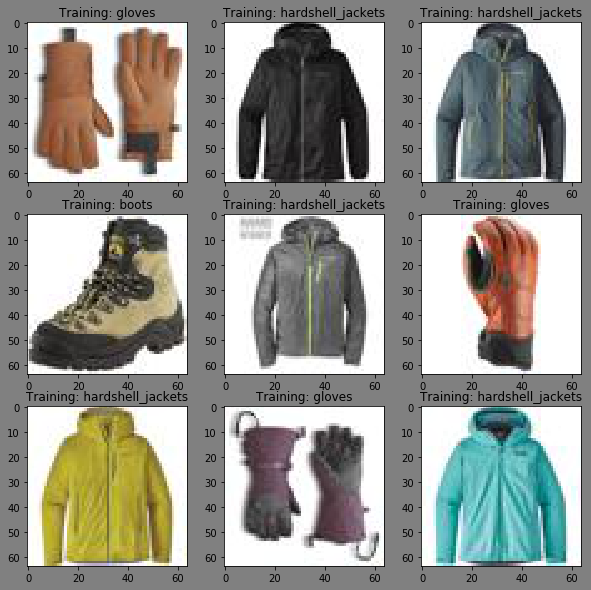

In [19]:
_, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
for ax, image, label in zip(axes.ravel(), X, y):
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Training: {}'.format(labels_array[label]))

### Challenge 1
How many images are in each class?

Print something that looks like:

```
boots has x images
gloves has y images
hardshell_jackets has z images
```

In [20]:
def count_in_classes(targets_array):
    """Count the number of images in each class
    We'll use the labels or targets array"""
    pass

count_in_classes(y)

### Classify the images

Support Vector Machine (with a polynomial kernel) is being used.  A polynomial kernel allows for non-linearity which we'll need in image data.

The data needs to be flattened from 3D arrays (64 x 64 x 3) to 1D arrays (12288 datapoint array).  Subsequently, the entire dataset will be a 2D array of shape (`n_samples`, `n_features`), where `n_samples` is the number of images and `n_features` is the total number of pixels in each image.  So, how many features are in this dataset?

In [21]:
# flatten the images to 1D arrays from 3D
n_samples = len(X)
data = X.reshape((n_samples, -1))

# Create a classifier: a support vector classifier
clf = svm.SVC(kernel='poly', degree=3, gamma='auto', C=1.0)

# Split data into 70% train and 30% test subsets
X_train, X_test, y_train, y_test = train_test_split(
    data, y, test_size=0.3, shuffle=False)

# Learn the digits on the train subset
clf.fit(X_train, y_train)

# Predict the value of the digit on the test subset
y_pred = clf.predict(X_test)

### Performance

Define:
- Precision
- Recall
- f1-score
- Support

Show:
- Metrics
- Confusion matrix

In [22]:
print(f"Classification report for classifier {clf}:\n"
      f"{metrics.classification_report(y_test, y_pred)}\n")

Classification report for classifier SVC(gamma='auto', kernel='poly'):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        37
           1       0.93      0.96      0.95        28
           2       0.98      0.95      0.97        44

    accuracy                           0.97       109
   macro avg       0.97      0.97      0.97       109
weighted avg       0.97      0.97      0.97       109




Confusion matrix:
[[37  0  0]
 [ 0 27  1]
 [ 0  2 42]]


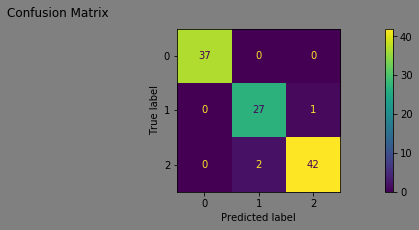

In [23]:
disp = metrics.plot_confusion_matrix(clf, X_test, y_test)
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")

plt.show()

### Check a few images from test set

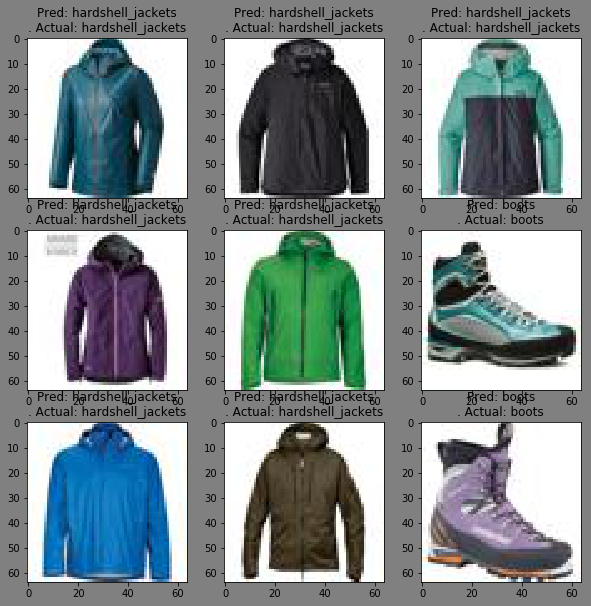

In [24]:
# images_test = images[len(X_train):]

_, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
for ax, image, pred, actual in zip(axes.ravel(), X_test, y_pred, y_test):
    # Must reshape our image to 3D
    image = image.reshape((64,64,3))
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Pred: {}\n. Actual: {}'.format(labels_array[pred], labels_array[actual]))

## Featurization example

**Histogram of Oriented Gradients (our featurizer)**

Code based on [this sample](https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html).  This type of featurizer is often used in object detection in conjunction with SVMs.

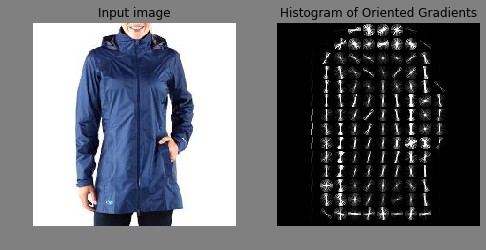

In [25]:
fd, hog_image = hog(img_padded, orientations=20, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True, multichannel=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(img_padded)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

## Scenario:  predicting the stock market with regression

In [26]:
data = pd.read_csv('data/daily_MSFT.csv', header=0)
data.head(10)

,timestamp,open,high,low,close,volume
0,2019-01-02,99.55,101.75,98.94,101.12,35329345
1,2018-12-31,101.29,102.40,100.44,101.57,33173765
2,2018-12-28,102.09,102.41,99.52,100.39,38169312
3,2018-12-27,99.30,101.19,96.40,101.18,49498509
4,2018-12-26,95.14,100.69,93.96,100.56,51634793
5,2018-12-24,97.68,97.97,93.98,94.13,43935192
6,2018-12-21,101.63,103.00,97.46,98.23,111242070
7,2018-12-20,103.05,104.31,98.78,101.51,70334184
8,2018-12-19,103.65,106.88,101.35,103.69,68198186
9,2018-12-18,103.75,104.51,102.52,103.97,49319196


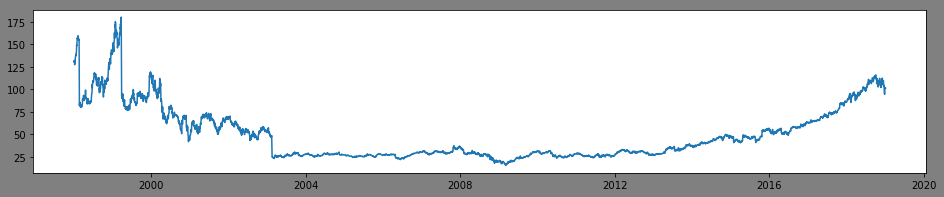

In [27]:
dates = pd.to_datetime(data['timestamp'])
dates
plt.plot(dates, data['close'])